# Проект: классификация

In [213]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SelectKBest, f_classif

## Часть 1. Знакомство с данными, обработка пропусков и выбросов

### Задание 1

In [214]:
df = pd.read_csv('data/bank_fin.csv', sep = ';')
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,"2 343,00 $",yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,"45,00 $",no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,"1 270,00 $",yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,"2 476,00 $",yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,"184,00 $",no,no,unknown,5,may,673,2,-1,0,unknown,yes


Данные о клиентах банка:

* age (возраст)
* job (сфера занятости)
* marital (семейное положение)
* education (уровень образования)
* default (имеется ли просроченный кредит)
* housing (имеется ли кредит на жильё)
* loan (имеется ли кредит на личные нужды)
* balance (баланс)

Данные, связанные с последним контактом в контексте текущей маркетинговой кампании:

* contact (тип контакта с клиентом)
* month (месяц, в котором был последний контакт)
* day (день, в который был последний контакт)
* duration (продолжительность контакта в секундах)

Прочие признаки:

* campaign (количество контактов с этим клиентом в течение текущей кампании)
* pdays (количество пропущенных дней с момента последней маркетинговой кампании до контакта в текущей кампании)
* previous (количество контактов до текущей кампании)
* poutcome (результат прошлой маркетинговой кампании)

Наша целевая переменная **deposit** определяет, согласится ли клиент открыть депозит в банке. Именно её мы будем пытаться предсказать в данном кейсе.

In [215]:
# исследуем данные на предмет пропусков
df.isna().sum()

age           0
job           0
marital       0
education     0
default       0
balance      25
housing       0
loan          0
contact       0
day           0
month         0
duration      0
campaign      0
pdays         0
previous      0
poutcome      0
deposit       0
dtype: int64

В признаке *balance* есть пропуски в данных. 

In [216]:
df['job'].value_counts()

management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: job, dtype: int64

После дополнительного исследования признаков выяснилось, что некоторые пропуски закодированы словом 'unknown'.

In [217]:
# преобразуем данные признака balance в тип float
df['balance'] = df['balance'].apply(lambda x: float(str(x).replace('$', '').replace(',00', '').replace(' ', '')))

In [218]:
# обработаем пропуски в признаке balance, заменив их на медианные значения по данному признаку
df['balance'] = df['balance'].fillna(df['balance'].median())

In [219]:
# обработаем пропуски в категориальных признаках: job и education, заменив их на модальные значения
df['job'] = df['job'].replace(['unknown'], df['job'].mode())
df['education'] = df['education'].replace(['unknown'], df['education'].mode())

print(f"Модальное значение в признаке job: {df['job'].mode()[0]}")
print(f"Модальное значение в признаке job: {df['education'].mode()[0]}")

Модальное значение в признаке job: management
Модальное значение в признаке job: secondary


In [220]:
# удалим все выбросы для признака balance по методу Тьюки
def outliers_iqr(data, feature):
    x = data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75)
    iqr = quartile_3-quartile_1
    lower_bound = quartile_1 - 1.5*iqr
    upper_bound = quartile_3 + 1.5*iqr
    outliers = data[(x<lower_bound) | (x>upper_bound)]
    cleaned = data[(x>=lower_bound) & (x<=upper_bound)]
    return lower_bound, upper_bound, outliers, cleaned

lower_bound, upper_bound, outliers, cleaned = outliers_iqr(df, 'balance')
print(f'Нижняя граница по методу Тьюки: {lower_bound}\nВерхняя граница по методу Тьюки: {upper_bound}')

print(f'Результирующее число записей: {cleaned.shape[0]}')

Нижняя граница по методу Тьюки: -2241.0
Верхняя граница по методу Тьюки: 4063.0
Результирующее число записей: 10105


## Часть 2:  Разведывательный анализ

no     5424
yes    4681
Name: deposit, dtype: int64


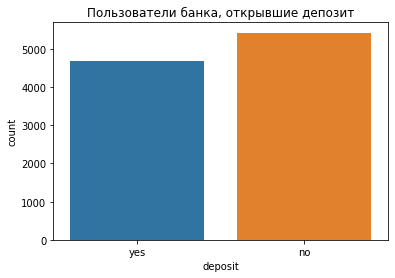

In [221]:
# изучим соотношение классов в данных на предмет несбалансированности
print(cleaned['deposit'].value_counts())

fig = plt.figure(figsize=(6, 4))
countplot = sns.countplot(data=cleaned, x='deposit')
countplot.set_title('Пользователи банка, открывшие депозит')

plt.show()

In [222]:
# рассчитаем описательные статистики для количественных переменных
print(f'Максимальный возраст клиента банка: {cleaned["age"].max()} лет.')
print(f'Минимальная продолжительность разговора с клиентом банка: {cleaned["duration"].min()} сек.')

Максимальный возраст клиента банка: 95 лет.
Минимальная продолжительность разговора с клиентом банка: 2 сек.


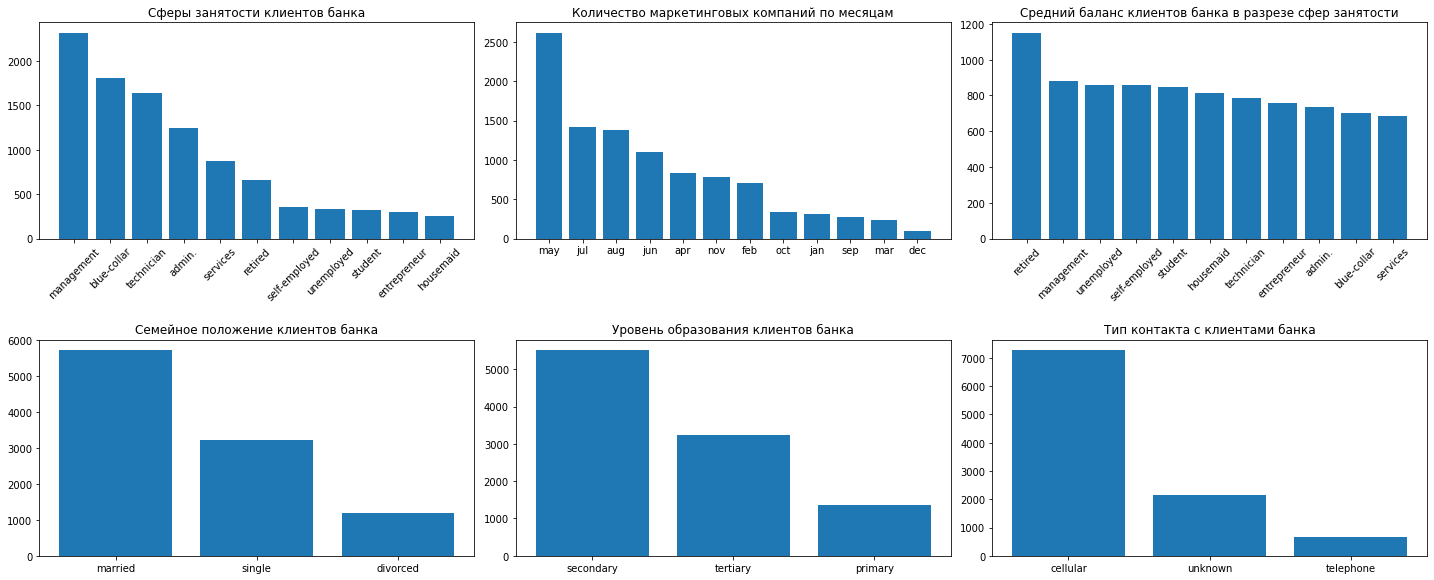

In [223]:
# рассчитаем описательные статистики для некоторых категориальных переменных
count_uniq_jobs = cleaned['job'].value_counts()
marketing_months = cleaned['month'].value_counts()
marital_types =  cleaned['marital'].value_counts()
education_types =  cleaned['education'].value_counts()
job_balance = cleaned.groupby('job')['balance'].mean().sort_values(ascending=False)
contact = cleaned['contact'].value_counts()

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(20, 8))
fig.tight_layout(h_pad=8)
ax[0][0].bar(x=count_uniq_jobs.index, height=count_uniq_jobs)
ax[0][0].xaxis.set_tick_params(rotation=45)
ax[0][0].set_title('Сферы занятости клиентов банка')

ax[0][1].bar(x=marketing_months.index, height=marketing_months)
ax[0][1].set_title('Количество маркетинговых компаний по месяцам')

ax[1][0].bar(x=marital_types.index, height=marital_types)
ax[1][0].set_title('Семейное положение клиентов банка')
    
ax[1][1].bar(x=education_types.index, height=education_types)
ax[1][1].set_title('Уровень образования клиентов банка')

ax[0][2].bar(x=job_balance.index, height=job_balance)
ax[0][2].set_title('Средний баланс клиентов банка в разрезе сфер занятости')
ax[0][2].xaxis.set_tick_params(rotation=45)

ax[1][2].bar(x=contact.index, height=contact)
ax[1][2].set_title('Тип контакта с клиентами банка')

plt.show()

- Свего среди клиентов банка предствалено 11 уникальных сфер занятости. Большинство клиентов банка состоят в браке и имеют среднее образование.

- Средний баланс клиентов банка для различных сфер занятости примерно одинаковый. В большую сторону выделяется лишь средний баланс клиентов, вышедших на пенсию.

- Большинство маркетинговых компаний банка проходили в мае, а также в летние месяцы.

- В основном банк контактирует со своими клиентами через мобильные телефоны.



In [224]:
# узнаем, для какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач.
cleaned.groupby('poutcome')['deposit'].value_counts()

poutcome  deposit
failure   no          562
          yes         547
other     yes         265
          no          216
success   yes         861
          no           84
unknown   no         4562
          yes        3008
Name: deposit, dtype: int64

In [225]:
# выясним, в каком месяце чаще всего отказывались от предложения открыть депозит
cleaned[cleaned['deposit']=='no'].groupby('deposit')['month'].value_counts(normalize=True)

deposit  month
no       may      0.327434
         jul      0.154130
         aug      0.142883
         jun      0.111726
         nov      0.084071
         feb      0.059550
         apr      0.058444
         jan      0.035767
         oct      0.011431
         sep      0.008481
         mar      0.004425
         dec      0.001659
Name: month, dtype: float64

Чаще всего от открытия депозита клиенты отказывались в мае. Но, как мы выяснили ранее, в мае также было самое большое количество маркетинговых кампаний.

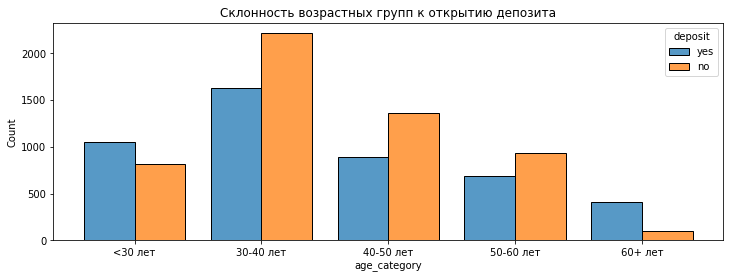

In [226]:
# создадим возрастные группы и определим, в каких группах более склонны открывать депозит, чем отказываться от предложения
cleaned['age_category'] = pd.cut(x=cleaned['age'], bins=[0, 30, 40, 50, 60, 100], labels=['<30 лет', '30-40 лет', '40-50 лет', '50-60 лет', '60+ лет'])

fig = plt.figure(figsize=(12,4))
histplot = sns.histplot(data=cleaned, x='age_category', hue='deposit', multiple='dodge', shrink=.8)
histplot.set_title('Склонность возрастных групп к открытию депозита')
plt.show()

Бόльшая часть людей относится к возрастной группе 30-40 лет. На открытие депозита более охотно соглашаются люди из возрастных групп *до 30 лет* и *более 60 лет*.

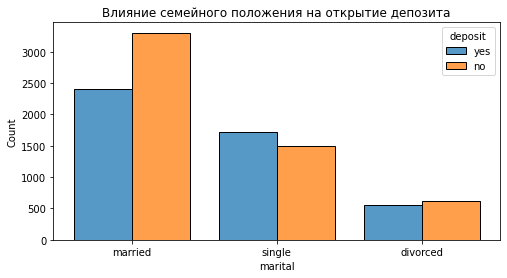

In [227]:
# построим визуализацию для открывших и неоткрывших депозит в зависимости от семейного статуса
fig = plt.figure(figsize=(8, 4))
histplot = sns.histplot(data=cleaned, x='marital', hue='deposit', multiple='dodge', shrink=.8)
histplot.set_title('Влияние семейного положения на открытие депозита')
plt.show()

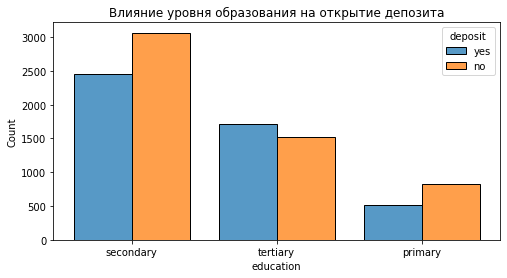

In [228]:
# построим визуализацию для открывших и неоткрывших депозит в зависимости от образования
fig = plt.figure(figsize=(8, 4))
histplot = sns.histplot(data=cleaned, x='education', hue='deposit', multiple='dodge', shrink=.8)
histplot.set_title('Влияние уровня образования на открытие депозита')
plt.show()

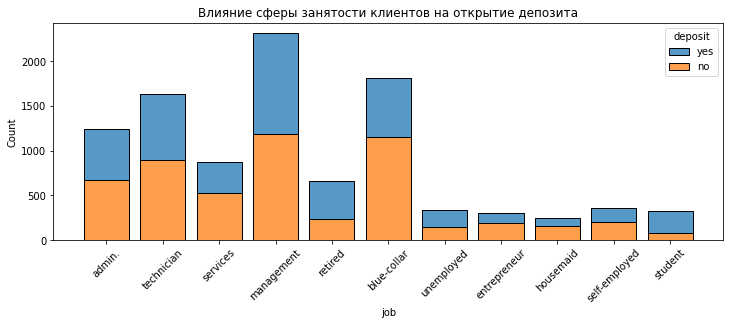

In [229]:
# построим визуализацию для открывших и неоткрывших депозит в зависимости от вида профессиональной занятости
fig = plt.figure(figsize=(12, 4))
histplot = sns.histplot(data=cleaned, x='job', hue='deposit', multiple='stack', shrink=.8)
plt.xticks(rotation = 45)
histplot.set_title('Влияние сферы занятости клиентов на открытие депозита')
plt.show()

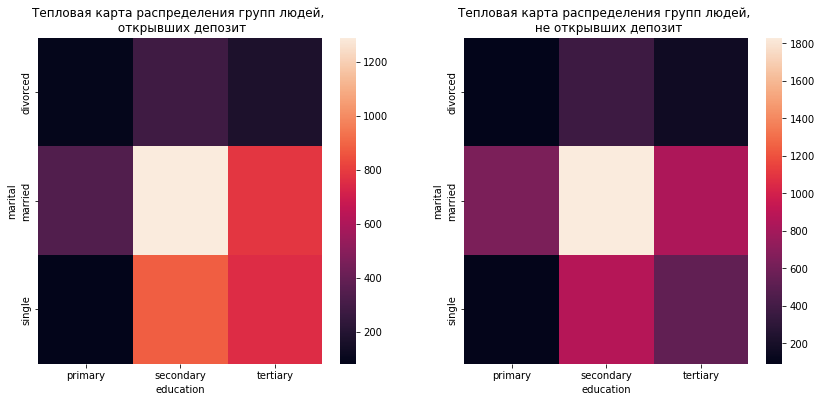

In [230]:
# построим сводную таблицу, чтобы определить люди с каким образованием и семейным статусом наиболее многочисленны
# (если рассматривать тех, кто открыл депозит)

yes_mask = cleaned['deposit']=='yes'
no_mask = cleaned['deposit']=='no'

yes_deposit = cleaned[yes_mask].groupby(['marital', 'education'])['marital'].count().unstack()
no_deposit = cleaned[no_mask].groupby(['marital', 'education'])['marital'].count().unstack()

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))
sns.heatmap(data = yes_deposit, ax=ax[0])
sns.heatmap(data = no_deposit, ax=ax[1])
ax[0].set_title('Тепловая карта распределения групп людей, \n открывших депозит')
ax[1].set_title('Тепловая карта распределения групп людей, \n не открывших депозит')
plt.show()

## Часть 3: преобразование данных

In [231]:
# закодируем признак уровня образования
data = cleaned.copy()
encoder = LabelEncoder()
data['education'] = encoder.fit_transform(data['education'])
data['age_category'] = encoder.fit_transform(data['age_category'])

In [232]:
# преобразуем бинарные переменные в представление из нулей и единиц

cols_to_change = ['default', 'housing', 'loan', 'deposit']
for col in cols_to_change:
    data[col] = data[col].apply(lambda x: 1 if x=='yes' else 0)

In [233]:
# закодируем бинарные признаки
cols_to_change = [col for col in data.columns if data[col].dtype=='O']
dum_data = pd.get_dummies(data)

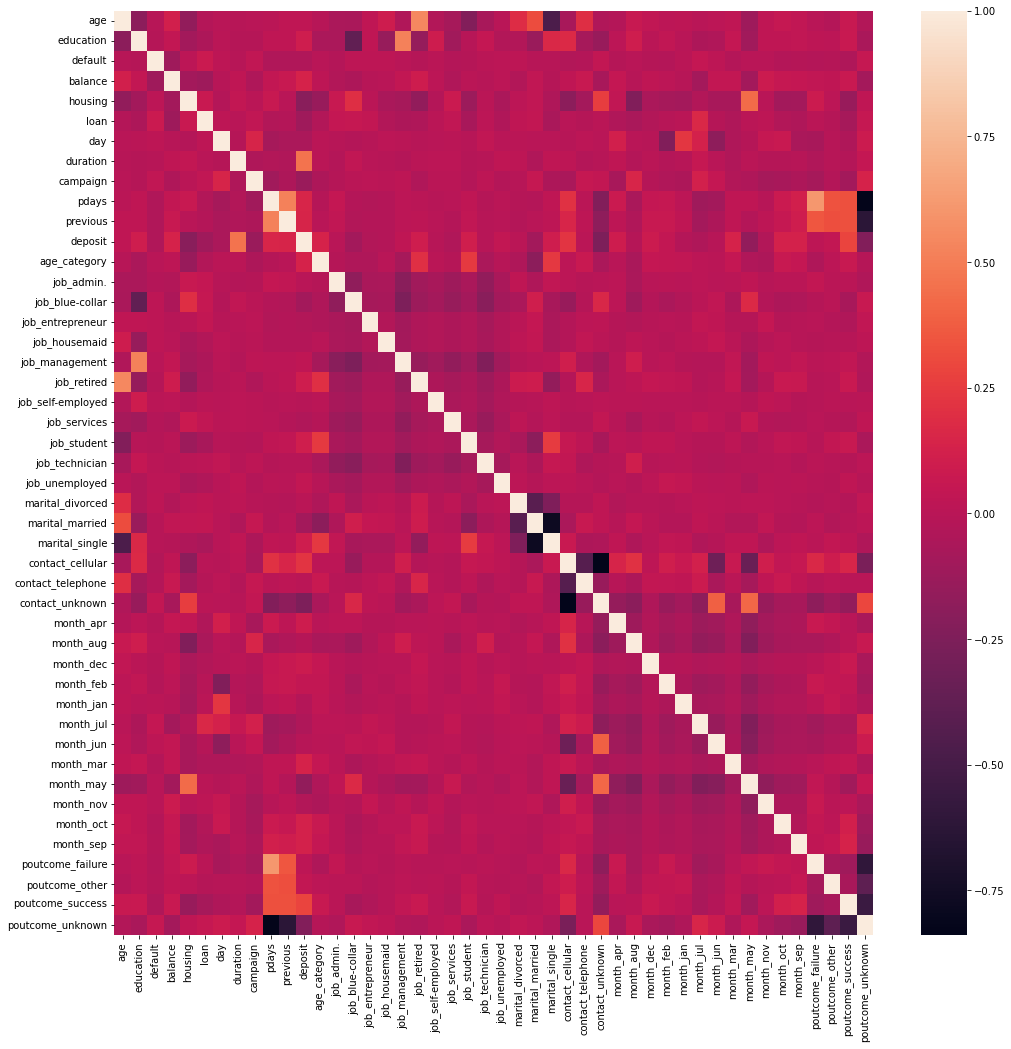

In [234]:
# построим корреляционную матрицу и оценим данные на предмет наличия мультиколлинеарности
corr = dum_data.corr()
max_corr = corr['deposit'].reset_index().sort_values('deposit', ascending=False)
max_corr.head(4)

fig = plt.figure(figsize=(17,17))
sns.heatmap(corr)

plt.show()

In [235]:
# разделим данные на тренировочную и тестовую выборки
X = dum_data.drop(['deposit'], axis=1)
y = dum_data['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

print('Размер тренировочной выборки: ', X_train.shape)
print('Размер тестовой выборки: ', X_test.shape)

Размер тренировочной выборки:  (6770, 45)
Размер тестовой выборки:  (3335, 45)


In [236]:
# с помощью SelectKBest отберём 15 наиболее подходящих признаков
kbest = SelectKBest(k=15, score_func=f_classif)
x = kbest.fit_transform(X_train, y_train)
columns_names = list(kbest.get_feature_names_out())
print(columns_names)
X_train, X_test = X_train[columns_names], X_test[columns_names]

['balance', 'housing', 'duration', 'campaign', 'pdays', 'previous', 'age_category', 'contact_cellular', 'contact_unknown', 'month_mar', 'month_may', 'month_oct', 'month_sep', 'poutcome_success', 'poutcome_unknown']


In [237]:
# нормализуем данные с помощью minmaxsxaler
mm_scaler = preprocessing.MinMaxScaler()
mm_scaler.fit(X_train)
X_train_scaled = mm_scaler.transform(X_train)
X_test_scaled = mm_scaler.transform(X_test)

# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

In [238]:
# обучим логистическую регрессию и рассчитаем метрику accuracy
log_reg = linear_model.LogisticRegression(solver='sag', random_state=42, max_iter=1000)
log_reg.fit(X_train_scaled, y_train)
y_test_pred = log_reg.predict(X_test_scaled)
print(f'f1 на тестовой выборке: {round(metrics.f1_score(y_test, y_test_pred), 2)}')

f1 на тестовой выборке: 0.78


In [239]:
# обучим решающие деревья и рассчитаем метрику accuracy
des_tree = tree.DecisionTreeClassifier(criterion = 'entropy', random_state=42, max_depth = 6)
des_tree.fit(X_train_scaled, y_train)
y_test_pred = des_tree.predict(X_test_scaled)
print(f'f1 на тестовой выборке: {round(metrics.f1_score(y_test, y_test_pred), 2)}')

f1 на тестовой выборке: 0.8


In [240]:
# подберём оптимальные параметры для DecisionTree с помощью gridsearch
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'max_depth':[5,7,10],
     'min_samples_split':[2, 5, 7, 10]}
]
grid_search = GridSearchCV(
    estimator=des_tree,
    param_grid=param_grid,
    cv=5,
    n_jobs=-1
)
grid_search.fit(X_train_scaled, y_train)
y_test_pred = grid_search.predict(X_test_scaled)
print(f'f1 на тестовой выборке: {round(metrics.f1_score(y_test, y_test_pred), 2)}')
grid_search.best_params_

f1 на тестовой выборке: 0.8


{'max_depth': 7, 'min_samples_split': 10}

# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

In [241]:
# обучим на наших данных случайный лес
rf = ensemble.RandomForestClassifier(
    n_estimators=100,
    criterion='gini',
    min_samples_leaf=5,
    max_depth=10,
    random_state=42
)
rf.fit(X_train_scaled, y_train)
y_test_pred = rf.predict(X_test_scaled)
print(f'f1 для тестового набора данных: {round(metrics.f1_score(y_test, y_test_pred), 2)}')

f1 для тестового набора данных: 0.82


In [242]:
# используем для классификации градиентный бустинг и сравним качество со случайным лесом
gb = ensemble.GradientBoostingClassifier(
    learning_rate=0.05,
    n_estimators=300,
    min_samples_leaf=5,
    max_depth=5,
    random_state=42
)
gb.fit(X_train_scaled, y_train)
y_test_pred = gb.predict(X_test_scaled)
print(f'f1 для тестового набора данных: {round(metrics.f1_score(y_test, y_test_pred), 2)}')

f1 для тестового набора данных: 0.82


In [243]:
# объединим использованные ранее алгоритмы с помощью стекинга. В качестве метамодели используем модель логистической регрессии
estimators = [
    ('log_reg', log_reg), 
    ('tree', des_tree), 
    ('gb', gb)
    ]
st_cl = ensemble.StackingClassifier(
    estimators=estimators,
    final_estimator=linear_model.LogisticRegression(random_state=42)
)
st_cl.fit(X_train_scaled, y_train)
y_pred_stack = st_cl.predict(X_test_scaled)
print(f'f1 для тестового набора данных: {round(metrics.f1_score(y_test, y_pred_stack), 2)}')

f1 для тестового набора данных: 0.81


In [244]:
# оценим, какие признаки демонстрируют наибольшую  важность в модели градиентного бустинга
from sklearn.feature_selection import RFE
 
estimator = ensemble.GradientBoostingClassifier()
selector = RFE(estimator, n_features_to_select=3, step=1)
selector = selector.fit(X_train, y_train)
 
print(f'Наиболее важные признаки: {selector.get_feature_names_out()}')

best_features = pd.DataFrame(
    data=selector.ranking_,
    index=X_train.columns,
    columns=['Rank']
)
best_features.sort_values(by='Rank')

Наиболее важные признаки: ['duration' 'contact_unknown' 'poutcome_success']


,Rank
duration,1
contact_unknown,1
poutcome_success,1
pdays,2
housing,3
age_category,4
month_mar,5
balance,6
month_oct,7
month_sep,8


In [245]:
# реализуем оптимизацию гиперпараметров с помощью Optuna для модели случайного леса
import optuna

def optuna_rf(trial):
    n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
    max_depth = trial.suggest_int('max_depth', 10, 30, 1)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)
    
    model = ensemble.RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_leaf=min_samples_leaf,
        random_state=42
    )
    
    model.fit(X_train_scaled, y_train)
    score = metrics.f1_score(y_train, model.predict(X_train_scaled))
    
    return score

In [248]:
%%time
# cоздаем объект исследования
# напрямую укажем, что нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=20)

[I 2022-11-09 20:54:49,710] A new study created in memory with name: RandomForestClassifier
[I 2022-11-09 20:54:50,387] Trial 0 finished with value: 0.8485705309456487 and parameters: {'n_estimators': 163, 'max_depth': 10, 'min_samples_leaf': 6}. Best is trial 0 with value: 0.8485705309456487.
[I 2022-11-09 20:54:51,137] Trial 1 finished with value: 0.8658441355614557 and parameters: {'n_estimators': 176, 'max_depth': 21, 'min_samples_leaf': 5}. Best is trial 1 with value: 0.8658441355614557.
[I 2022-11-09 20:54:51,827] Trial 2 finished with value: 0.8799624882775868 and parameters: {'n_estimators': 163, 'max_depth': 21, 'min_samples_leaf': 4}. Best is trial 2 with value: 0.8799624882775868.
[I 2022-11-09 20:54:52,516] Trial 3 finished with value: 0.8542870529439325 and parameters: {'n_estimators': 176, 'max_depth': 12, 'min_samples_leaf': 6}. Best is trial 2 with value: 0.8799624882775868.
[I 2022-11-09 20:54:53,232] Trial 4 finished with value: 0.8602825745682888 and parameters: {'n_

CPU times: total: 17.4 s
Wall time: 17.5 s


In [249]:
# выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study.best_params))
# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(**study.best_params, random_state=42)
model.fit(X_train_scaled, y_train)
y_test_pred = model.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

Наилучшие значения гиперпараметров {'n_estimators': 136, 'max_depth': 28, 'min_samples_leaf': 2}
f1_score на тестовом наборе: 0.82


Ансамблевые модели дают наилучшие показатели метрики F1 в сравнении с более простыми моделями. Наилучшее значение метрики F1, которое удалось получить: 0,82.

Также мы попрактиковались в применении различных вариантов оптимизации моделей.